# Создание DataLoader

In [1]:
!pip install wfdb
!pip install peakutils
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 7.3 MB/s eta 0:00:00


In [2]:
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import scale
from wfdb import rdrecord
from scipy.signal import butter, lfilter, freqz, hilbert
import peakutils
import pandas as pd
from torch import nn
from torch.optim import lr_scheduler
from tqdm import tqdm, tqdm_notebook
import sklearn.metrics as mtr
import seaborn as sns
import json
import torch
from scipy.signal import find_peaks
from torch.utils.data import DataLoader, Dataset
from torchmetrics import F1Score
import torch.nn.functional as F


if os.path.isdir("mitdb"):
    print('You already have the data.')
else:
    wfdb.dl_database('mitdb', 'mitdb')

Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generating record list for: 209
Generati

In [3]:

# Choose from peak to peak or centered
# mode = [20, 20]
mode = 128

image_size = 128
output_dir = '/content/data'  # Assuming the data is in the mitdb folder in Colab

# dpi fix
fig = plt.figure(frameon=False)
dpi = fig.dpi

# fig size / image size
figsize = (image_size / dpi, image_size / dpi)
image_size = (image_size, image_size)


# Assuming your data is in the /content/mitdb folder
mitdb_folder = '/content/mitdb'

for file_name in os.listdir(mitdb_folder):
    file_path = os.path.join(mitdb_folder, file_name[:-4])
    record =  rdrecord(file_path)
    ann = wfdb.rdann(file_path, extension='atr')

    for sig_name, signal in zip(record.sig_name, record.p_signal.T):
        if not np.all(np.isfinite(signal)) or sig_name != "MLII":
            continue
        signal = scale(signal)
        for i, (label, peak) in enumerate(zip(ann.symbol, ann.sample)):
            if label == '/':
                label = "\\"
            print('\r{} [{}/{}]'.format(sig_name, i + 1, len(ann.symbol)), end="")
            if isinstance(mode, list):
                if np.all([i > 0, i + 1 < len(ann.sample)]):
                    left = ann.sample[i - 1] + mode[0]
                    right = ann.sample[i + 1] - mode[1]
                else:
                    continue
            elif isinstance(mode, int):
                left, right = peak - mode // 2, peak + mode // 2
            else:
                raise Exception("Wrong mode in script beginning")

            if np.all([left > 0, right < len(signal)]):
                one_dim_data_dir = os.path.join(output_dir, '1D', file_name, sig_name, label)
                os.makedirs(one_dim_data_dir, exist_ok=True)

                filename = os.path.join(one_dim_data_dir, '{}.npy'.format(peak))
                np.save(filename, signal[left:right])



MLII [1876/1876]

<Figure size 640x480 with 0 Axes>

In [16]:
class EcgDataset1D(Dataset):
    def __init__(self, ann_path, mapping_path, sampler = None):
        super().__init__()
        self.data = json.load(open(ann_path))
        self.mapper = json.load(open(mapping_path))
        self.sampler = sampler

    def __getitem__(self, index):
        img = np.load(self.data[index]["path"]).astype("float32")
        img = img.reshape(1, img.shape[0])
        return {"image": img, "class": self.mapper[self.data[index]["label"]]}

    def get_dataloader(self, num_workers=2, batch_size=16, shuffle=False):
        data_loader = DataLoader(
            self, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, sampler = self.sampler,
        )
        return data_loader

    def __len__(self):
        return len(self.data)


def callback_get_label(dataset, idx):
    return dataset[idx]["class"]

In [17]:
val_loader = EcgDataset1D(
            "/content/val.json","/content/class-mapper.json",
        ).get_dataloader(batch_size=128)

In [18]:
data = next(iter(val_loader))
data

{'image': tensor([[[-0.0717, -0.0510, -0.1028,  ...,  0.2186,  0.2808,  0.3222]],
 
         [[ 0.7488,  0.7488,  0.7041,  ..., -0.7050, -0.8168, -0.7945]],
 
         [[ 0.6627,  0.7291,  0.7955,  ...,  1.0278,  1.0278,  0.9946]],
 
         ...,
 
         [[ 0.0127,  0.0744,  0.0744,  ..., -0.8636, -0.9007, -0.8883]],
 
         [[-0.1704, -0.2768, -0.3122,  ...,  1.0529,  1.0174,  1.0174]],
 
         [[ 0.1608,  0.1485,  0.1979,  ..., -0.5551, -0.5180, -0.5057]]]),
 'class': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0])}

# Baseline

Определим первую, наивную модель. Предсказанием данной модели будет константа, в нашем случае N - 0, так как самый встречающийся класс

In [19]:
size = 0
accuracy = 0
f1_score = 0
f1 = F1Score(task = "multiclass", num_classes = 6)
for data in val_loader:
    predict = torch.zeros(data['class'].size())
    accuracy += torch.sum(data['class'] == predict)
    f1_score += f1(predict , data["class"])
    size += predict.size(0)

print("Accuracy val", accuracy.numpy() / size)
print("F1-score", f1_score.numpy() / len(val_loader))

Accuracy val 0.7692074556751023
F1-score 0.7626201923076923


Из-за несбалансированных данных accuracy = 0.769

# DL model

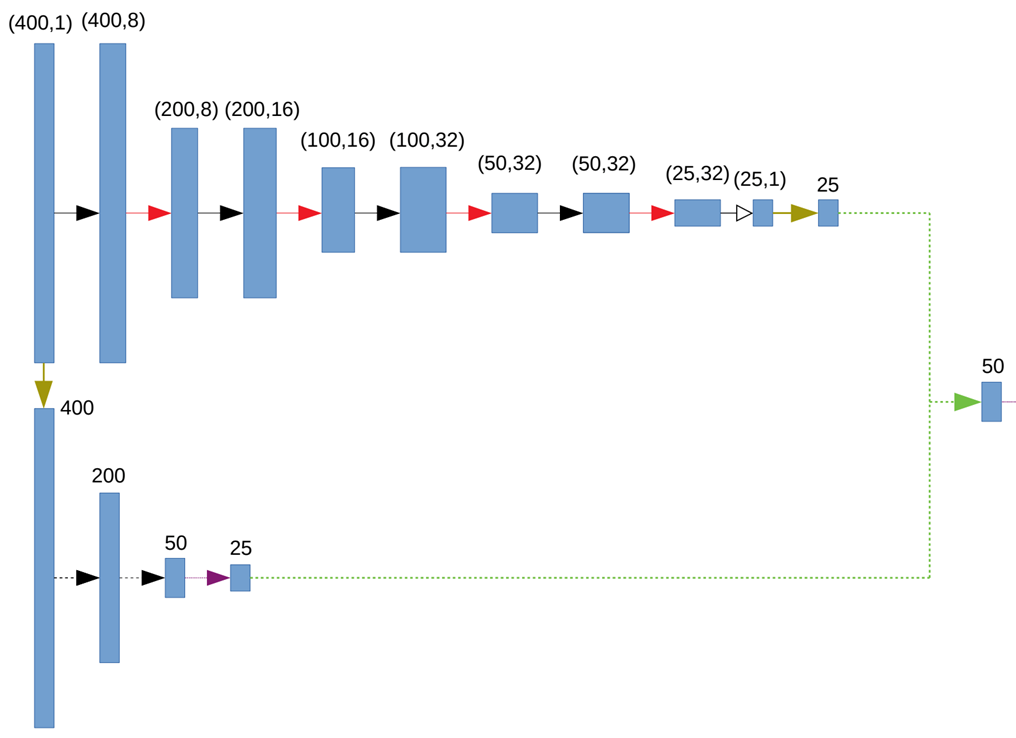

In [20]:
DEVICE = torch.device("cuda")

In [21]:
class ECGnet(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()

        self.features_up = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=3, padding=1),
            nn.BatchNorm1d(8),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),
            nn.Conv1d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 1, kernel_size=3, padding=1),
            nn.Flatten()
            #Flatten(),
        )

        self.features_down = nn.Sequential(
            nn.Flatten(),
            #Flatten(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(inplace=True),
            nn.Linear(16, 8),
        )

        self.classifier = nn.Linear(8, num_classes)

    def forward(self, x):
        out_up = self.features_up(x)
        out_down = self.features_down(x)
        out_middle = out_up + out_down

        out = self.classifier(out_middle)

        return out

In [22]:
def fit_epoch(model, train_loader, criterion, optimizer, sheduler = None):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    f1_score = 0
    f1 = F1Score(task="multiclass", num_classes = 6).to(DEVICE)
    for data in train_loader:
        inputs, labels = data.values()
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = outputs.argmax(-1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        f1_score += f1(preds, labels.data)
        processed_data += inputs.size(0)

    if sheduler is not None:
        sheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    train_f1 = f1_score.cpu().numpy() / len(train_loader)
    return train_loss, train_acc, train_f1

In [23]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    f1_score = 0
    f1 = F1Score(task="multiclass", num_classes = 6).to(DEVICE)
    for data in val_loader:
        inputs, labels = data.values()
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = outputs.argmax(-1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        f1_score += f1(preds, labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    val_f1_score = f1_score.double() / len(val_loader)
    return val_loss, val_acc, val_f1_score

In [24]:
def train(train_loader, val_loader, model, epochs, optimizer=None, criterion=None, sheduler=None):

    if optimizer is None:
      optimizer = torch.optim.Adam(model.parameters())

    if criterion is None:
      criterion = nn.CrossEntropyLoss()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    best_f1 = 0.0
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} train_f1 {t_f1:0.4f} val_acc {v_acc:0.4f} val_f1 {v_f1:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):
            train_loss, train_acc, train_f1 = fit_epoch(model, train_loader, criterion, optimizer, sheduler)
            print("loss", train_loss)

            val_loss, val_acc, val_f1 = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, train_f1, val_loss, val_acc, val_f1))
            if val_acc > best_acc and val_f1 > best_f1:
                best_f1 = val_f1
                best_acc = val_acc
                best_model_wts = model.state_dict()

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc,t_f1 = train_f1, v_acc=val_acc, v_f1 = val_f1))

    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    torch.save(model, 'model.pth')

    return model, history

In [26]:
train_loader = EcgDataset1D(
            "/content/train.json","/content/class-mapper.json",
              ).get_dataloader(batch_size=128)

val_loader = EcgDataset1D(
            "/content/val.json","/content/class-mapper.json",
              ).get_dataloader(batch_size=128)

model = ECGnet()

model.to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [27]:
model, history = train(train_loader, val_loader, model=model, epochs=5, optimizer=optimizer, sheduler=exp_lr_scheduler)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 0.212448286688069


epoch:  20%|██        | 1/5 [00:22<01:28, 22.06s/it]


Epoch 001 train_loss: 0.2124     val_loss 0.0672 train_acc 0.9454 train_f1 0.9455 val_acc 0.9841 val_f1 0.9787
loss 0.059143392379032864


epoch:  40%|████      | 2/5 [00:38<00:56, 18.94s/it]


Epoch 002 train_loss: 0.0591     val_loss 0.0465 train_acc 0.9850 train_f1 0.9850 val_acc 0.9882 val_f1 0.9837
loss 0.041920380234755736


epoch:  60%|██████    | 3/5 [00:55<00:35, 17.93s/it]


Epoch 003 train_loss: 0.0419     val_loss 0.0375 train_acc 0.9887 train_f1 0.9887 val_acc 0.9900 val_f1 0.9855
loss 0.034428821895008246


epoch:  80%|████████  | 4/5 [01:12<00:17, 17.38s/it]


Epoch 004 train_loss: 0.0344     val_loss 0.0340 train_acc 0.9905 train_f1 0.9905 val_acc 0.9914 val_f1 0.9872
loss 0.029717490357899928


epoch: 100%|██████████| 5/5 [01:28<00:00, 17.78s/it]


Epoch 005 train_loss: 0.0297     val_loss 0.0312 train_acc 0.9918 train_f1 0.9918 val_acc 0.9911 val_f1 0.9867
Best val Acc: 0.991362


In [28]:
from sklearn.metrics import confusion_matrix, classification_report

model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for data in val_loader:
        inputs, labels = data.values()
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        predicted = outputs.argmax(-1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(true_labels, predicted_labels)
class_report = classification_report(true_labels, predicted_labels, digits = 5)

print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[5070    0    0    2    1    3]
 [   1  181    0    0    0    0]
 [   1    0  361    0    0    0]
 [  10    1    1  469    1    0]
 [   1    0    0    0  448    0]
 [  36    0    0    0    1   11]]

Classification Report:
              precision    recall  f1-score   support

           0    0.99043   0.99882   0.99461      5076
           1    0.99451   0.99451   0.99451       182
           2    0.99724   0.99724   0.99724       362
           3    0.99575   0.97303   0.98426       482
           4    0.99335   0.99777   0.99556       449
           5    0.78571   0.22917   0.35484        48

    accuracy                        0.99106      6599
   macro avg    0.95950   0.86509   0.88683      6599
weighted avg    0.99001   0.99106   0.98940      6599



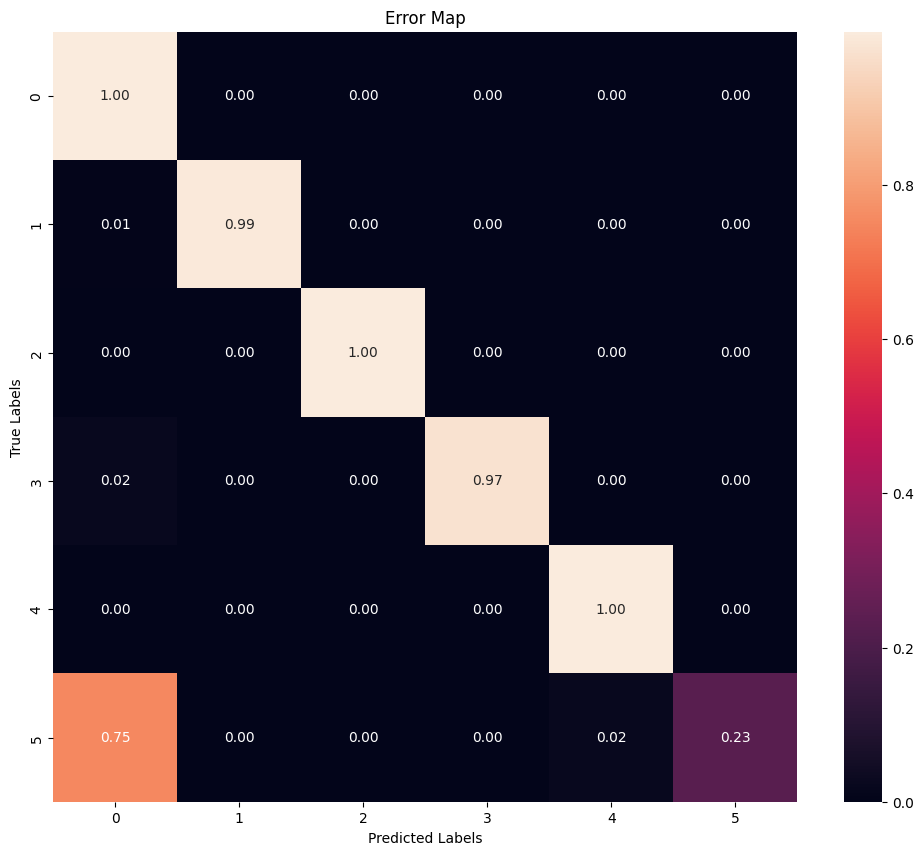

In [29]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

error_map = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)

plt.figure(figsize=(12, 10))
sns.heatmap(error_map, annot=True, fmt=".2f")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Error Map")
plt.show()

In [103]:
import plotly.graph_objects as go

class EcgPipelineDataset1D(Dataset):
    def __init__(self, path, mode=128):
        super().__init__()
        record = wfdb.rdrecord(path)
        self.signal = None
        self.mode = mode
        for sig_name, signal in zip(record.sig_name, record.p_signal.T):
            if sig_name in ["MLII", "II"] and np.all(np.isfinite(signal)):
                self.signal = scale(signal).astype("float32")
        if self.signal is None:
            raise Exception("No MLII LEAD")

        self.peaks = find_peaks(self.signal, distance=180)[0]
        mask_left = (self.peaks - self.mode // 2) > 0
        mask_right = (self.peaks + self.mode // 2) < len(self.signal)
        mask = mask_left & mask_right
        self.peaks = self.peaks[mask]

    def __getitem__(self, index):

        images = []
        peaks = []
        pred_peaks = 0
        for i in range(index, index + self.mode):
          peak_i = self.peaks[i]
          left_i, right_i = peak_i - self.mode // 2, peak_i + self.mode // 2
          img_i = self.signal[left_i:right_i]
          img_i = img_i.reshape(1, -1)
          images.append(img_i)
          peaks.append(img_i.argmax() + pred_peaks)
          pred_peaks += self.mode

        return {"image": torch.tensor(images), "peak": torch.tensor(peaks)}

    def get_dataloader(self, num_workers=4, batch_size=16, shuffle=True):
        data_loader = DataLoader(
            self, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers,
        )
        return data_loader

    def __len__(self):
        return len(self.peaks)

class BasePipeline:
    def __init__(self, model, data_loader, path, beats = 30):
        self.path = path
        self.model = model
        self.beats = beats
        self.pipeline_loader = data_loader

        self.mapper = json.load(open("class-mapper .json"))
        #self.mapper = {j: i for i, j in self.mapper.items()}

    def run_pipeline(self):
        self.model.eval()
        pd_class = np.empty(0)
        pd_peaks = np.empty(0)

        with torch.no_grad():
            #for i, (batch) in tqdm(enumerate(self.pipeline_loader)):
                batch = next(iter(self.pipeline_loader))
                inputs = batch["image"]
                inputs = torch.tensor(inputs)
                inputs = inputs.to(DEVICE)
                predictions = self.model(inputs)

                classes = predictions.topk(k=1)[1].view(-1).cpu().numpy()
                pd_class = np.concatenate((pd_class, classes))
                pd_peaks = np.concatenate((pd_peaks, batch["peak"]))

        pd_class = pd_class.astype(int)[:self.beats]
        pd_peaks = pd_peaks.astype(int)[:self.beats]


        inputs = inputs.cpu().numpy()[:self.beats]
        inputs = inputs.squeeze(1).reshape(128*self.beats)
        annotations = []
        for i, (label, peak) in enumerate(zip(pd_class, pd_peaks)):
            if label != 0:
                annotations.append(
                    {
                        "x": peak,
                        "y": inputs[peak]-0.1,
                        "text": self.mapper.get(str(label)),
                        "xref": "x",
                        "yref": "y",
                        "showarrow": True,
                        "arrowcolor": "black",
                        "arrowhead": 1,
                        "arrowsize": 2,
                    },
                )

        fig = go.Figure(
            data=go.Scatter(
                x=list(range(len(inputs))),
                y=inputs,
            ),
        )
        fig.update_layout(
            title="ECG",
            xaxis_title="Time",
            yaxis_title="ECG Output Value",
            title_x=0.5,
            annotations=annotations,
            #autosize=True,
            height=400,  # Set the desired height of the graph
            width=800,
        )

        html_ECG = fig.write_html(
            os.path.join("/content/", os.path.basename(self.path + ".html")),
        )
        class_mapper = json.load(open("class-mapper .json"))
        pd_class = [class_mapper.get(str(value)) for value in pd_class]
        return pd_peaks, pd_class, html_ECG,


In [104]:
inference_loader = EcgPipelineDataset1D("/content/mitdb/105")

In [105]:
pipline = BasePipeline(model, inference_loader, "test", 30)

In [106]:
peaks, predict, html = pipline.run_pipeline()

<ipython-input-103-7999376fd863>:65: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [77]:
peaks

array([ 64, 192, 320, 448, 576])

In [78]:
predict

['Normal', 'Normal', 'Normal', 'Normal', 'Normal']

# _!#@_@$

Попробуем использовать WeightedRandomSampler для того, чтобы в каждом батче в зависимости от веса встречались разные метки

In [ ]:
train_data = pd.read_json("/content/train.json")
count = train_data["label"].value_counts()

In [ ]:
from sklearn.preprocessing import LabelEncoder

cnt = count.get

count_weights = {k: 1/v for k,v in count.items()}
sample_weights = len(train_data) * [0]

In [ ]:
train_data.head()

,name,lead,label,filename,path,numeric_label
0,200.dat,MLII,N,456405,/content/data/1D/200.dat/MLII/N/456405.npy,0
1,215.hea,MLII,N,378570,/content/data/1D/215.hea/MLII/N/378570.npy,0
2,203.dat,MLII,N,248277,/content/data/1D/203.dat/MLII/N/248277.npy,0
3,105.dat,MLII,N,559699,/content/data/1D/105.dat/MLII/N/559699.npy,0
4,212.atr,MLII,R,14981,/content/data/1D/212.atr/MLII/R/14981.npy,1


In [ ]:
import torch
from torch.utils.data import WeightedRandomSampler
import json

label_mapper = json.load(open("class-mapper .json"))

train_data['numeric_label'] = train_data['label'].map(label_mapper)

labels = torch.tensor(train_data['numeric_label'].values)

class_counts = torch.bincount(labels)
class_weights = 1.0 / class_counts.float()

weights = class_weights[labels]

sampler = WeightedRandomSampler(weights, len(weights))

In [ ]:
train_data = EcgDataset1D(
            "/content/train.json","/content/class-mapper .json", sampler = sampler,
        ).get_dataloader(batch_size=128)

In [ ]:
next(iter(train_data))

{'image': tensor([[[-0.7276, -0.6772, -0.6469,  ..., -0.6065, -0.5561, -0.5157]],
 
         [[-0.1039, -0.1358, -0.1146,  ..., -0.8272, -0.8698, -0.8804]],
 
         [[ 0.8185,  0.8034,  0.8638,  ...,  1.4071,  1.3618,  1.3769]],
 
         ...,
 
         [[ 0.5331,  0.5140,  0.5714,  ..., -0.4816, -0.4816, -0.5582]],
 
         [[-0.1848, -0.1724, -0.1230,  ..., -0.8389, -0.8019, -0.8019]],
 
         [[-0.0568, -0.1021, -0.1172,  ...,  0.6525,  0.8034,  1.0600]]]),
 'class': tensor([0, 4, 1, 3, 5, 2, 2, 5, 0, 1, 3, 4, 4, 1, 2, 2, 2, 0, 2, 0, 4, 1, 0, 2,
         2, 2, 5, 2, 1, 4, 2, 4, 5, 0, 4, 2, 4, 5, 1, 3, 2, 2, 3, 3, 0, 5, 0, 1,
         2, 1, 3, 2, 0, 4, 0, 1, 0, 2, 2, 1, 4, 5, 0, 1, 2, 4, 3, 3, 4, 1, 0, 3,
         1, 5, 3, 1, 4, 2, 4, 2, 0, 5, 1, 2, 3, 0, 3, 1, 4, 1, 1, 3, 0, 5, 2, 4,
         5, 1, 0, 0, 1, 2, 5, 3, 2, 2, 5, 2, 0, 0, 1, 0, 0, 3, 4, 3, 4, 5, 2, 1,
         3, 1, 5, 0, 0, 0, 0, 1])}

Работа с исходными данными

In [ ]:
class EcgPipelineDataset1D(Dataset):
    def __init__(self, path, mode=128):
        super().__init__()
        record = wfdb.rdrecord(path)
        self.signal = None
        self.mode = mode
        for sig_name, signal in zip(record.sig_name, record.p_signal.T):
            if sig_name in ["MLII", "II"] and np.all(np.isfinite(signal)):
                self.signal = scale(signal).astype("float32")
        if self.signal is None:
            raise Exception("No MLII LEAD")

        self.peaks = find_peaks(self.signal, distance=180)[0]
        mask_left = (self.peaks - self.mode // 2) > 0
        mask_right = (self.peaks + self.mode // 2) < len(self.signal)
        mask = mask_left & mask_right
        self.peaks = self.peaks[mask]

    def __getitem__(self, index):
        peak = self.peaks[index]
        left, right = peak - self.mode // 2, peak + self.mode // 2

        img = self.signal[left:right]
        img = img.reshape(1, img.shape[0])

        return {"image": img, "peak": peak}

    def get_dataloader(self, num_workers=4, batch_size=16, shuffle=True):
        data_loader = DataLoader(
            self, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers,
        )
        return data_loader

    def __len__(self):
        return len(self.peaks)

In [ ]:
loader = EcgPipelineDataset1D("/content/mitdb/100").get_dataloader(batch_size=128)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
next(iter(loader))

{'image': tensor([[[ 0.4467,  0.4726,  0.4467,  ..., -0.2780, -0.3297, -0.3038]],
 
         [[ 0.3173,  0.2914,  0.3432,  ..., -0.8214, -0.8473, -0.7438]],
 
         [[ 0.1102,  0.1879,  0.2138,  ..., -0.6662, -0.6144, -0.5885]],
 
         ...,
 
         [[ 0.8608,  0.8090,  0.8349,  ..., -0.0709, -0.0709, -0.2003]],
 
         [[ 0.4467,  0.4467,  0.4208,  ..., -0.7179, -0.7956, -0.8473]],
 
         [[ 0.6020,  0.6278,  0.7572,  ..., -0.2262, -0.2780, -0.2262]]]),
 'peak': tensor([492445, 299206, 388373, 549785, 325216, 410477, 322573, 369715,   7953,
          62547, 184934, 449138, 440314, 136061, 261968,  16465, 554439, 235250,
          83795, 437118, 510221, 474074, 267679, 617087,  26952, 160002, 574430,
         503794, 432509,  37500, 587030, 312605, 363027,  17359, 365640,  17657,
         306641, 380899, 372007, 106315, 555614,  18227, 200715, 371132, 427828,
         129520, 486557, 133390,  41850, 222952, 248300, 393077, 452101, 416556,
         433365, 595993, 104546

In [ ]:
img = np.load(data[0]['path'])

array([-7.17006018e-02, -5.09681221e-02, -1.02799321e-01, -1.33898041e-01,
       -9.24330815e-02, -8.20668417e-02,  8.63077182e-04,  4.23280366e-02,
        5.26942765e-02,  4.23280366e-02,  6.30605163e-02,  9.41592359e-02,
        1.66722915e-01,  2.18554114e-01,  1.87455395e-01,  1.97821634e-01,
        1.87455395e-01,  2.18554114e-01,  2.28920354e-01,  2.28920354e-01,
        1.77089155e-01,  1.25257955e-01,  8.37929960e-02,  1.25257955e-01,
        1.45990435e-01,  1.25257955e-01,  5.26942765e-02, -1.98694025e-02,
       -8.20668417e-02, -1.02799321e-01, -8.20668417e-02, -7.17006018e-02,
       -9.24330815e-02, -1.23531801e-01, -1.75363000e-01, -1.85729240e-01,
       -1.33898041e-01, -1.44264281e-01, -1.54630521e-01, -1.75363000e-01,
       -1.96095480e-01, -1.64996761e-01, -1.44264281e-01, -1.33898041e-01,
       -1.64996761e-01, -1.96095480e-01, -1.96095480e-01, -1.85729240e-01,
       -1.44264281e-01, -1.64996761e-01, -1.85729240e-01, -2.27194200e-01,
       -2.47926679e-01, -